# Softmax Classifier exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- 实现一个完全向量化的Softmax分类器的损失函数。
- 实现其解析梯度的完全向量化表达式
- 使用数值梯度检查你的实现
- 使用验证集调优学习率和正则化强度
- 使用SGD优化损失函数
- 可视化最终学习到的权重
- implement a fully-vectorized **loss function** for the Softmax classifier.
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


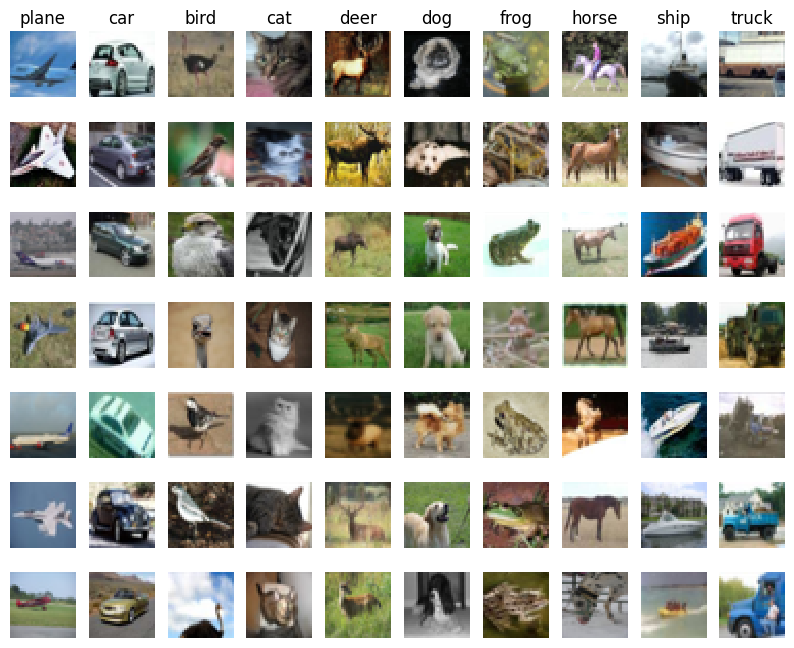

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


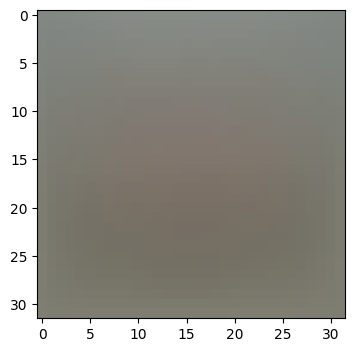

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.

As you can see, we have prefilled the function `softmax_loss_naive` which uses for loops to evaluate the softmax loss function.

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, our loss should be something close to -  log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.341548
loss: 2.341548
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.

$\color{blue}{\textit Your Answer:}$ softmax 权重矩阵 W 并未通过 dW 使用如梯度下降法进行训练. 并且 W 初始值为全 0 矩阵, 根据 softmax 算法计算出 Loss 值为-log(0.1).




The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the softmax loss function and implement it inline inside the function `softmax_loss_naive`. You 
will find it helpful to interleave your new code inside the existing function.
To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have 
provided code that does this for you:
上面函数返回的 `grad`（梯度）目前全为零。请推导并实现 softmax 损失函数的梯度，并将其直接写在 `softmax_loss_naive` 函数内部。你会发现将新代码与已有代码交错编写会更方便。
为了检查你是否正确实现了梯度，你可以用数值方法估算损失函数的梯度，并将其与你计算得到的梯度进行比较。我们已经为你提供了相关代码来完成这个检查：

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.427397 analytic: 0.427397, relative error: 5.918263e-08
numerical: 4.372399 analytic: 4.372398, relative error: 1.833995e-08
numerical: 2.545867 analytic: 2.545867, relative error: 2.984160e-08
numerical: 1.148383 analytic: 1.148383, relative error: 4.190829e-08
numerical: 1.346450 analytic: 1.346450, relative error: 6.133935e-09
numerical: 0.111592 analytic: 0.111592, relative error: 4.022594e-07
numerical: 0.363843 analytic: 0.363843, relative error: 1.440988e-07
numerical: 0.951239 analytic: 0.951239, relative error: 1.425222e-08
numerical: 1.451410 analytic: 1.451410, relative error: 8.091181e-09
numerical: -2.168470 analytic: -2.168470, relative error: 5.804240e-09
numerical: 3.006569 analytic: 3.006569, relative error: 1.384905e-09
numerical: -1.017203 analytic: -1.017203, relative error: 5.623094e-08
numerical: -4.395487 analytic: -4.395487, relative error: 2.295608e-08
numerical: 1.163790 analytic: 1.163790, relative error: 3.210695e-08
numerical: 0.144107 analytic

**Inline Question 2**

Although gradcheck is reliable softmax loss, it is possible that for SVM loss, once in a while, a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a svm loss gradient check could fail? How would change the margin affect of the frequency of this happening?

Note that SVM loss for a sample $(x_i, y_i)$ is defined as: $$L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$$ where $j$ iterates over all classes except the correct class $y_i$ and $s_j$ denotes the classifier score for $j^{th}$ class. $\Delta$ is a scalar margin. For more information, refer to 'Multiclass Support Vector Machine loss' on [this](https://cs231n.github.io/linear-classify/) page.

*Hint: the SVM loss function is not strictly speaking differentiable.*

尽管梯度检查对于softmax损失是可靠的，但对于SVM损失，有时候梯度检查中的某个维度可能不会完全匹配。这种差异可能由什么原因造成？这是否值得担忧？在一维情况下，SVM损失梯度检查可能失败的简单例子是什么？改变边界margin会如何影响这种情况发生的频率？

注意，对于样本$(x_i, y_i)$，SVM损失定义为：$$L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$$，其中$j$遍历除了正确类别$y_i$以外的所有类别，$s_j$表示第$j$类的分类器得分。$\Delta$是一个标量边界值。更多信息，请参考[此页面](https://cs231n.github.io/linear-classify/)上的"多类支持向量机损失"部分。

*提示：严格来说，SVM损失函数不是可微的。*


$\color{blue}{\textit Your Answer:}$ 

**margin 的含义**

边界(margin)表示正确类别的分数与其他类别分数之间应该保持的最小差距。

在公式 $L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$ 中：

- $\Delta$ 就是 margin（通常设为 1）

- 它强制要求正确类别的分数 $s_{y_i}$ 至少要比任何错误类别的分数 $s_j$ 高出 $\Delta$ 的量

实际意义：边界相当于安全距离，让模型不仅能够正确分类，还能有足够的 "自信度"。边界越大，要求模型的判别能力越强。

**可能导致数值梯度与解析梯度不完全匹配的原因**

- SVM 损失含有 hinge 函数：$max(0, s_j – s_{y_i} + Δ)$。
- 当 $s_j – s_{y_i} + Δ = 0 $ 时，hinge 函数的拐点上“左导数”和“右导数”是不一样的 —— 损失函数在该点上不可微。
- 数值梯度检查是用 $f(w+ε) – f(w–ε) $ 去近似导数，如果 w 恰好让 $ s_j – s_{y_i} + Δ$ 非常接近 0，那么对称扰动 $ ±ε $ 可能让你一边落在“损失为 0”的平坦区，一边落在“损失 > 0”的区域，就会得出一个不对称的差分商，和解析梯度（通常我们选 subgradient = 0 或 = 对应斜率）不符。
- 这种现象只是因为 hinge 在拐点不可微，不会影响我们用 subgradient（次梯度）或其它优化方法正常训练。

**这是不是一个需要担心的问题**？

- 不必担心, 在绝大多数参数点上，hinge loss 是处处可微的（要么恒为 0，要么在平滑区间内）；只有在 W 的几个元素恰好取了比较巧合的值使得得分差正好等于 margin 的时候才有一个孤立的拐点。而且在某点处 hinge loss 不可微的频率始终非常低，也不依赖于 margin 的大小。
- 优化算法（SGD、subgradient descent、或者现代的 subgradient descent）都支持在不可微点处使用“次梯度”／“子梯度”（subgradient）来更新参数，一样能收敛。

**一维简单例子说明 SVM 损失梯度检查如何失败**
假设只有两个类别（j = 正类/负类），样本输入 x = 1，真实标签 y =+1。记模型输出正类得分 $s_{+}=w·1=w$，负类得分 $ s_{-}=0$（为了简单）。取 margin Δ = 1。

- 损失 $L(w)=max(0, s_{-} – s_{+} + Δ)=max(0, 0 – w + 1)=max(0, 1–w)$。
- 解析梯度：
  - 当 w < 1 时，L = 1–w，可导，∂L/∂w =–1；
  - 当 w > 1 时，L = 0，可导，∂L/∂w = 0；
  - 当 w = 1 时，L = 0，左右导数分别为 –1（从左）和 0（从右），所以不可微；subgradient 可取 [–1, 0] 之间的任意值。
- 数值梯度检查：
  - 取 ε = 1e–5，检查点 w = 1：
    $f(1+ε)=L(1+ε)=max(0,1–（1+ε))=0；$
    $f(1–ε)=L(1–ε)=max(0,1–(1–ε))=ε；$
    $差分商 ≈ (0–ε)/(2ε)=–1/2.$
  - 解析梯度在 w = 1 处我们可能选择 subgradient = 0 或 =–1，都和 –0.5 不一致。
- 这就说明在拐点附近 finite‐difference 会给出一个“介于两者之间”的值，和我们选的子梯度不吻合。







In [14]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()

print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.341548e+00 computed in 0.086519s
Vectorized loss: 2.341548e+00 computed in 0.002837s
difference: 0.000000


In [15]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.043538s
Vectorized loss and gradient: computed in 0.001955s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [16]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 774.625078
iteration 100 / 1500: loss 284.345433
iteration 200 / 1500: loss 105.229214
iteration 300 / 1500: loss 39.869515
iteration 400 / 1500: loss 15.822511
iteration 500 / 1500: loss 7.214465
iteration 600 / 1500: loss 3.955144
iteration 700 / 1500: loss 2.729621
iteration 800 / 1500: loss 2.320483
iteration 900 / 1500: loss 2.187809
iteration 1000 / 1500: loss 2.151627
iteration 1100 / 1500: loss 2.084621
iteration 1200 / 1500: loss 2.140311
iteration 1300 / 1500: loss 2.135116
iteration 1400 / 1500: loss 2.086433
That took 4.795621s


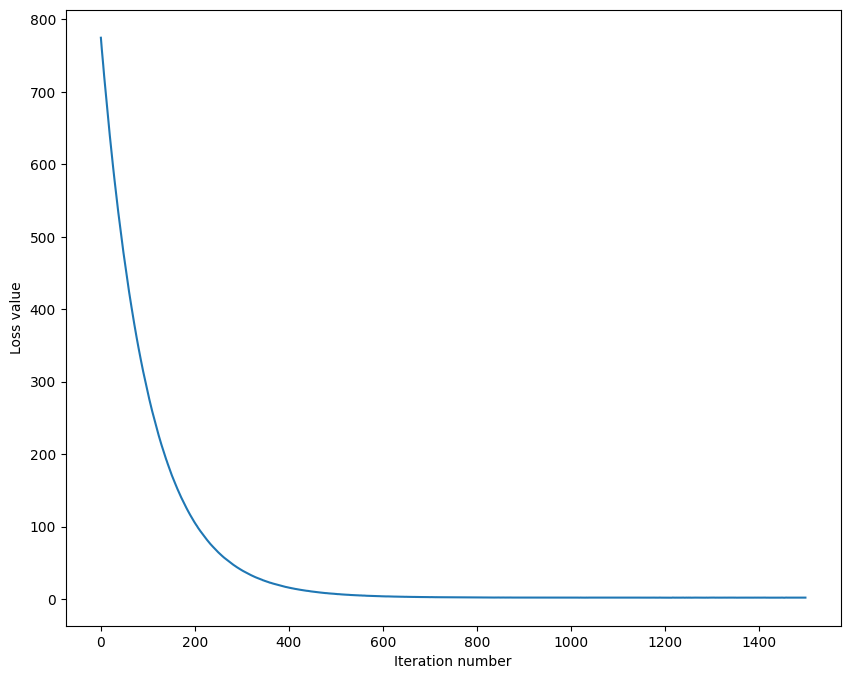

In [17]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [18]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.329694
validation accuracy: 0.340000


In [22]:
# Save the trained model for autograder.
softmax.save("softmax.npy")

softmax.npy saved.


In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.


learning_rates = [1e-9, 1e-7, 1e-6, 1.25e-7, 1e-4]
regularization_strengths = [1e2, 1e4, 3e4, 9e4, 1e6]
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters = 1500, 
                      batch_size=200, verbose=False)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax



# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

d:\GitProjects\CS231n\assignments\assignment1\cs231n\classifiers\softmax.py:91: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(p[np.arange(num_train), y]))
d:\GitProjects\CS231n\assignments\assignment1\cs231n\classifiers\softmax.py:92: RuntimeWarning: overflow encountered in scalar multiply
  loss = loss / num_train + reg * np.sum(W * W)
d:\GitProjects\CS231n\assignments\assignment1\cs231n\classifiers\softmax.py:92: RuntimeWarning: overflow encountered in multiply
  loss = loss / num_train + reg * np.sum(W * W)
d:\GitProjects\CS231n\assignments\assignment1\cs231n\classifiers\softmax.py:96: RuntimeWarning: overflow encountered in multiply
  dW = dW / num_train + 2 * reg * W
d:\GitProjects\CS231n\assignments\assignment1\cs231n\classifiers\softmax.py:86: RuntimeWarning: invalid value encountered in matmul
  s = X@W


lr 1.000000e-09 reg 1.000000e+02 train accuracy: 0.104918 val accuracy: 0.091000
lr 1.000000e-09 reg 1.000000e+04 train accuracy: 0.125122 val accuracy: 0.126000
lr 1.000000e-09 reg 3.000000e+04 train accuracy: 0.099143 val accuracy: 0.097000
lr 1.000000e-09 reg 9.000000e+04 train accuracy: 0.106796 val accuracy: 0.100000
lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.138429 val accuracy: 0.131000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.254082 val accuracy: 0.251000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.353184 val accuracy: 0.369000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.322163 val accuracy: 0.342000
lr 1.000000e-07 reg 9.000000e+04 train accuracy: 0.297367 val accuracy: 0.308000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.252245 val accuracy: 0.257000
lr 1.250000e-07 reg 1.000000e+02 train accuracy: 0.260898 val accuracy: 0.270000
lr 1.250000e-07 reg 1.000000e+04 train accuracy: 0.355612 val accuracy: 0.372000
lr 1.250000e-07 reg 3.000000

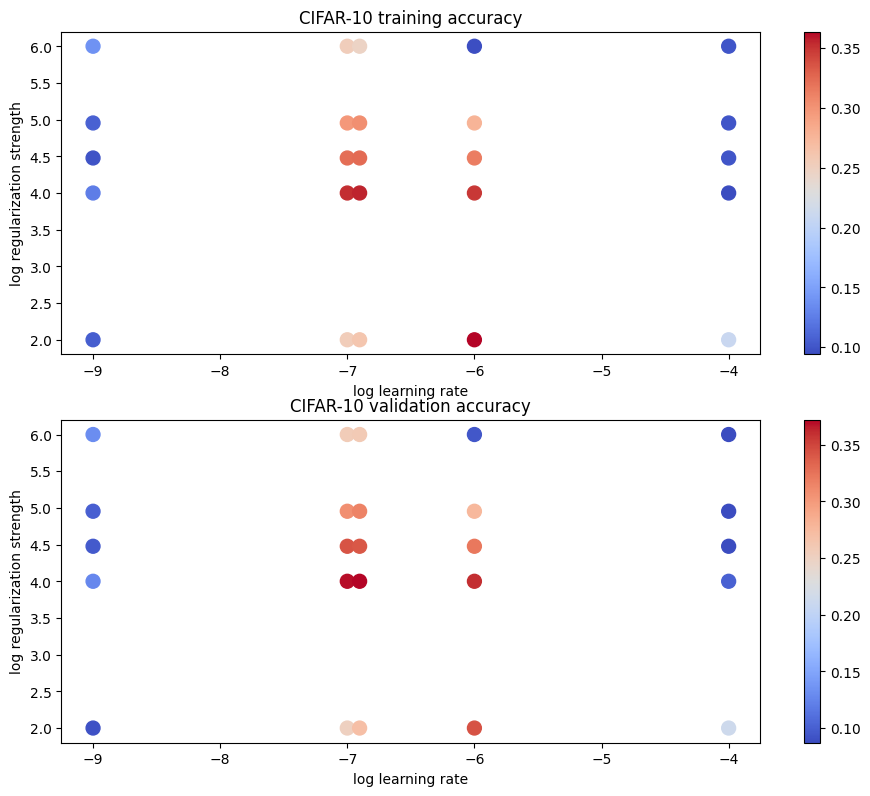

In [26]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [27]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.363000


In [28]:
# Save best softmax model
best_softmax.save("best_softmax.npy")

best_softmax.npy saved.


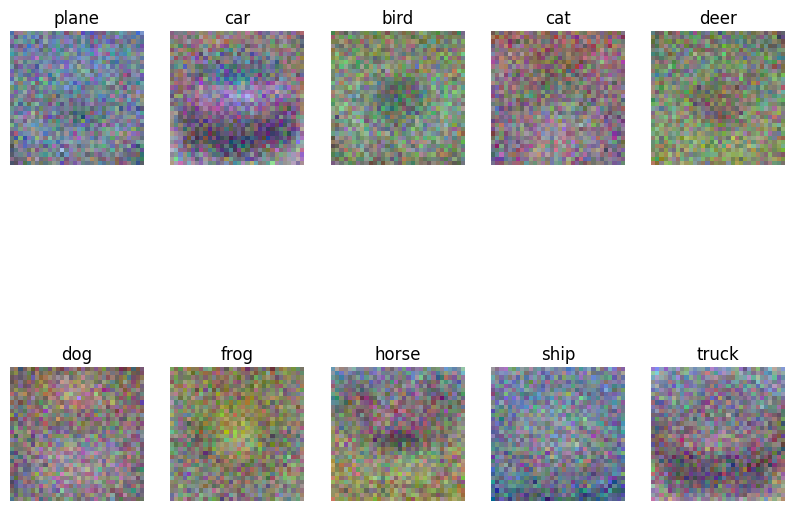

In [29]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # 去掉偏置项，只保留权重部分。这里的切片操作[:-1,:]表示取除了最后一行之外的所有行，保留所有列
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # 将权重重新缩放到0到255之间，以便可以显示为图像
    # 首先提取第i类的权重，然后减去最小值并除以范围(最大值-最小值)进行归一化到[0,1]
    # 最后乘以255转换为标准图像像素值范围
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline Question 3**

Describe what your visualized Softmax classifier weights look like, and offer a brief explanation for why they look the way they do.

描述你可视化的 Softmax classifier 权重图片，并简要说明它们为何呈现该形态。

$\color{blue}{\textit Your Answer:}$

可视化的权重总体表现为带有颜色和局部纹理的噪声图像，有些较为显著而有些较为杂乱。

产生这种现象的原因在于模型学习得到的特征以边缘颜色和局部纹理为主，在模型参数少，样本种类少的情况下权重会有噪声化的情况。

**Inline Question 4**

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would change the softmax loss, but leave the SVM loss unchanged.

假设整体训练损失被定义为所有训练样本上每个数据点损失的总和。可以在训练集中添加一个新的数据点，这将改变 softmax 损失，但保持 SVM 损失不变。

$\color{blue}{\textit Your Answer:}$

True.

SVM 损失为：$L_i = ∑_{j≠y_i} max(0, s_j - s_{y_i} + Δ)$

一旦正确类别分数超过其他类别分数足够多（至少 Δ），损失就变为 0

Softmax 损失为：$L_i = -log(e^{s_{y_i}}/∑_j e^{s_j})$

只有当正确类别的概率接近 1 时（其他类别概率接近 0），损失才接近 0

**举例**:

考虑添加这样一个数据点：正确类别的分数恰好比其他类别高 Δ+ε（ε 很小）, 例如：$s_{y_i} = 10$, 其他所有 $s_j = 8, Δ = 1$.

对于这个数据点：

- Softmax 损失：$-log(e^{10}/(e^{10} + e^8 + ...)) ≈ -log(0.x) > 0$
- SVM 损失：所有 $max(0, s_j - s_{y_i} + Δ) = max(0, 8 - 10 + 1) = max(0, -1) = 0$